# Sketching AutoEncoder with line connectivity prediction

This notebook demonstrates an autoencoder that predicts both a list of 2d points and an approximately binary connection matrix for those points. Lines between each possible pair of points are drawn into separate rasters and these are weighted by the respective weight in the connection matrix before being merged into a single image with a compositing function. Only the encoder network has learnable parameters; the decoder is entirely deterministic, but differentiable.

The network is defined below; the number of points can be configured and we can control whether to allow points to connect to themselves (allowing drawing of single points) or not.

In [1]:
import torch
import torch.nn as nn
from dsketch.raster.disttrans import line_edt2
from dsketch.raster.raster import exp
from dsketch.raster.composite import softor

class AE(nn.Module):
  def __init__(self, npoints=10, hidden=64, sz=28, allow_points=True):
    super(AE, self).__init__()

    # build the coordinate grid:
    r = torch.linspace(-1, 1, sz)
    c = torch.linspace(-1, 1, sz)
    grid = torch.meshgrid(r, c)
    grid = torch.stack(grid, dim=2)
    self.register_buffer("grid", grid)

    # if we allow points, we compute the upper-triangular part of the symmetric connection
    # matrix including the diagonal. If points are not allowed, we don't need the diagonal values
    # as they would be implictly zero
    if allow_points:
        nlines = int((npoints**2 + npoints) / 2)
    else:
        nlines = int(npoints * (npoints-1) / 2)
    self.coordpairs = torch.combinations(torch.arange(0, npoints, dtype=torch.long), r=2, with_replacement=allow_points)
    
    # shared part of the encoder
    self.enc1 = nn.Sequential(
        nn.Linear(sz**2, hidden),
        nn.ReLU(),
        nn.Linear(hidden, hidden),
        nn.ReLU())
    # second part for computing npoints 2d coordinates (using tanh because we use a -1..1 grid)
    self.enc_pts = nn.Sequential(
        nn.Linear(hidden, npoints*2),
        nn.Tanh())
    # second part for computing upper triangular part of the connection matrix
    self.enc_con = nn.Sequential(
        nn.Linear(hidden, nlines),
        nn.Sigmoid())

  def forward(self, inp, sigma=1e-4):
    # the encoding process will flatten the input and
    # push it through the encoder networks
    bs = inp.shape[0]
    x = inp.view(bs, -1)
    z = self.enc1(x)
    pts = self.enc_pts(z) #[batch, npoints*2]
    pts = pts.view(bs, -1, 2) # expand -> [batch, npoints, 2]
    conn = self.enc_con(z)  #[batch, nlines]
    
    # compute all valid permuations of line start and end points
    lines = torch.stack((pts[:,self.coordpairs[:,0]], pts[:,self.coordpairs[:,1]]), dim=-2) #[batch, nlines, 2, 2]

    # Rasterisation steps
    # draw the lines (for every input in the batch)
    rasters = exp(line_edt2(lines, self.grid), sigma) # -> [batch * nlines, 28, 28]
    
    # weight by the values in the connection matrix
    rasters = rasters * conn.view(bs, -1, 1, 1)
    
    # composite
    return softor(rasters)

We'll do a simple test on MNIST and try and train the AE to be able to reconstruct digit images (and of course at the same time perform image vectorisation/autotracing of polylines). Hyperparameters are pretty arbitrary (defaults for Adam; 256 batch size), although we do anneal the rasteriser scale each epoch (to a point) to initially allow better gradient flow from further away.

In [2]:
import matplotlib.pyplot as plt
from torchvision.datasets.mnist import MNIST
from torchvision import transforms
import torchvision

batch_size = 256

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(28, 28))
    ])
trainset = torchvision.datasets.MNIST('/tmp', train=True, transform=transform, download=True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)

testset = torchvision.datasets.MNIST('/tmp', train=False, transform=transform, download=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)


sigma=1e-1
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = AE(npoints=6, allow_points=True).to(device)

opt = torch.optim.Adam(model.parameters())

for epoch in range(10):
  for images, classes in trainloader:
    images = images.to(device)
    opt.zero_grad()
    out = model(images, sigma)
    loss = nn.functional.mse_loss(out, images)
    loss.backward()
    opt.step()

  if sigma > 1e-2:
    sigma *= 0.5

  print(loss, sigma)

tensor(0.0596, device='cuda:0', grad_fn=<MseLossBackward>) 0.05
tensor(0.0525, device='cuda:0', grad_fn=<MseLossBackward>) 0.025
tensor(0.0409, device='cuda:0', grad_fn=<MseLossBackward>) 0.0125
tensor(0.0356, device='cuda:0', grad_fn=<MseLossBackward>) 0.00625
tensor(0.0375, device='cuda:0', grad_fn=<MseLossBackward>) 0.00625
tensor(0.0330, device='cuda:0', grad_fn=<MseLossBackward>) 0.00625
tensor(0.0322, device='cuda:0', grad_fn=<MseLossBackward>) 0.00625
tensor(0.0307, device='cuda:0', grad_fn=<MseLossBackward>) 0.00625
tensor(0.0278, device='cuda:0', grad_fn=<MseLossBackward>) 0.00625
tensor(0.0267, device='cuda:0', grad_fn=<MseLossBackward>) 0.00625


Finally here's a visualisation of a set of test inputs and their rendered reconstructions:

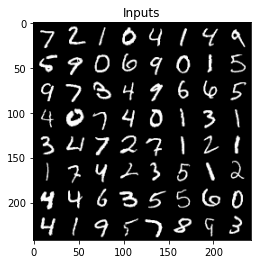

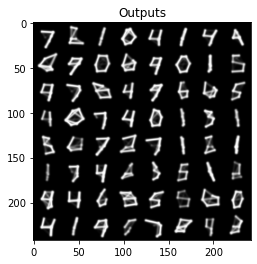

In [3]:
batch = iter(testloader).next()[0][0:64]
out = model(batch.to(device), sigma=1e-2)

plt.figure()
inputs = torchvision.utils.make_grid(batch.unsqueeze(1))
plt.title("Inputs")
plt.imshow(inputs.permute(1,2,0))

plt.figure()
outputs = torchvision.utils.make_grid(out.detach().cpu().unsqueeze(1))
plt.title("Outputs")
plt.imshow(outputs.permute(1,2,0))